# ABM simulation of the Social Cycling app

This agent based simulation has been developed to aid in the design of
"[Social Cycling](https://gitlab.com/rgarcia-herrera/social-cycling/)",
a mobile app that helps with the coordination of bike
riders so that flocks are assembled in a simple and spontaneous way.

A description that follows the [ODD protocol](https://doi.org/10.1016/j.ecolmodel.2010.08.019) can be read in the [narrative document](narrative_doc.md).


## Model

### The Flock class

Flock objects have a size, centroid, and mean speed. 

In [1]:
# this library computes distances and headings
from LatLon import LatLon, Latitude, Longitude

class Flock:
    def __init__(self, bikes):
        """
        Flock object is created from a list of agents
        and has a useful centroid
        """

        lats = list()
        lons = list()

        n = 0
        for b in bikes:
            lats.append(b.lat)
            lons.append(b.lon)
            n += 1

        if n > 0:
            self.size = n
            self.centroid = LatLon(Latitude(sum(lats) / len(lats)),
                                   Longitude(sum(lons) / len(lons)))
        else:
            self.size = 0
            self.centroid = None

### The Bike class

The **Bike** class inherits from [road_agent](https://pypi.org/project/road-agent/)'s Agent class.

The **find_flock** method seeks other agents that are nearby and with similar destinations.

The **flocking_step** method uses **find_flock** to update the agent's route so that it will go through the centroid of found flocks.

In [2]:
from road_agent import Agent


def within_radius(A, B, radius):
    """ 
    A, B are LatLon points
    radius expressed in meters
    """
    if A.distance(B) * 1000.0 < radius:
        return True
    else:
        return False


class Bike(Agent, object):
    
    def __init__(self, **kwargs):
        super(Bike, self).__init__(**kwargs)
        self.status = 'solo'
        self.flock_size = 0
        self.speed = 4
        self.update_route()

    def in_flock(self):
        # consider agents within this radius around agent
        flock_radius = 2 * self.speed
        
        flock_degrees = 5  # agents inside flock_radius are flocking with me 
                           # if their headings are this similar to mine
        
        my_flock = set([bike for bike in N
                        if (within_radius(self.point(),
                                          bike.point(),
                                          flock_radius)
                            and
                            abs(self.heading - bike.heading) <= flock_degrees)])
        my_flock.remove(self)
        if len(my_flock) > 0:
            self.status = 'flocking'
            self.flock_size = len(my_flock)
            self.speed = 3.5
            self.update_route()
            return True
        else:
            return False        

    
    def find_flock(self, point_altruism=0.1, dest_altruism=0.2):
        """
        :return: list of Bike objects
        """

        voyage_len = self.distance_to(self.destination())

        local_radius = voyage_len * point_altruism
        destination_radius = voyage_len * dest_altruism

        # these are bikes around me
        local = set([bike for bike in N
                     if within_radius(self.point(),
                                      bike.point(),
                                      local_radius)])

        # these are going near my destination
        remote = set([bike for bike in N
                      if within_radius(self.destination(),
                                       bike.destination(),
                                       destination_radius)])
                      

        # intersect them!
        flock = local.intersection(remote)
        
        # remove self
        flock.remove(self)

        return flock    
    
    def flocking_step(self):
        """
        Seek other agents to flock with. Update route to join them. Update agent status.
        """
        
        if not self.in_flock():
            flock = Flock(self.find_flock())
        
            if flock.size > 0:
                self.status = 'seeking'
                
                flock_heading = self.point().heading_initial(flock.centroid)
                dest_heading = self.point().heading_initial(self.destination())
                if abs(dest_heading - flock_heading) > 90:
                    # flock away from my destination, better wait
                    self.speed = random.uniform(1.5, 2)
                else:
                    # flock towards my destination, better catch up
                    self.speed = random.uniform(4.5, 6)
                
                self.flock_size = 0
                self.update_route([flock.centroid, ])
            else:
                self.status = 'solo'
                self.flock_size = 0
                self.speed = 4
                self.update_route()
            
        self.step()

## Input

The input for this simulation is a street network, obtained through the [OSMNX](https://pypi.org/project/OSMnx/) library which can download a square around a given point.

Nodes from this street network will be used to set random origins and destinations for bikers.

In [3]:
import osmnx as ox
ox.config(log_file=True, log_console=True, use_cache=True)

%matplotlib inline
import matplotlib.pyplot as plt

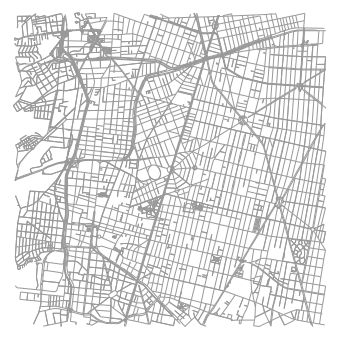

In [4]:
# Grab a square somewhere in Mexico City.
# Setting a distance of 2500 creates a square bounding box with 5km on each side.
G = ox.graph_from_point((19.3838, -99.1758), distance=2500)

# Another useful method:
#G = ox.graph_from_place('Tzintzuntzan, Michoacan, Mexico', network_type='bike')

fig, ax = ox.plot_graph(G, node_size=0)

## Initialization

### Create BRouter instance
 
The road_agent library uses BRouter to create paths for agents as they navigate the street network. Be sure to start a BRouter server.

In [5]:
from road_agent.router import BRouter

# passing no arguments uses the default local instance
router = BRouter()

### Create agents with random trips

In [6]:
import random

def random_trip(G, min_dist, max_dist):
    """
    Return random Origin and Destination points such that
    the distance between them whithin min_dist and max_dist
    which are expressed in meters
    """
    while True:
        origin_id = random.choice([osmid for osmid in G.nodes])
        
        origin = LatLon(G.nodes[origin_id]['y'],
                        G.nodes[origin_id]['x'])

        
        dest_id = random.choice([osmid for osmid in G.nodes])
        
        dest = LatLon(G.nodes[dest_id]['y'],
                      G.nodes[dest_id]['x'])
        
        if (origin.distance(dest) * 1000.0 >= min_dist
            and origin.distance(dest) * 1000.0 <= max_dist):
            return origin, dest

In [7]:
number_of_agents = 125    # for 50 riders per square km per hour
min_trip_distance = 4000  # meters
max_trip_distance = 5000  # meters

N = []  # agent population
for n in range(number_of_agents):
    origin, destination = random_trip(G, min_trip_distance, max_trip_distance)
    b = Bike(point=origin,
             dest=destination,
             router=router)
    N.append(b)

## Run simulation

In [8]:
simulation_steps = 600
try_to_flock_every_seconds = 10

import numpy as np
observe = {
    id(b): {
        'lon': np.zeros(simulation_steps), 
        'lat': np.zeros(simulation_steps),
        'status': ["" for t in range(simulation_steps)],
        'flock_size': np.zeros(simulation_steps)
    } 
    for b in N
}

for t in range(simulation_steps):
    for b in N:
        observe[id(b)]['lon'][t] = b.lon
        observe[id(b)]['lat'][t] = b.lat        
        observe[id(b)]['status'][t] = b.status
        observe[id(b)]['flock_size'][t] = b.flock_size
        if not b.got_there():
            if t % try_to_flock_every_seconds == 0:
                b.flocking_step()
            else:
                b.step()
        else:
            b.status = 'arrived'

## Analisis of observations

Default simulation is run with a density of 50 rides per square kilometer per hour. For the default 5 km square the **number_of_agents** is 125.

The **number_of_agents** variable can be adjusted in the Initialization section. 

| number of agents     | density in rides/km2/h |
|----------------------|------------------------|
|                  125 | 	                 50 |
|                  250 |                    100 |
|                  500 | 	                200 |
|                 1000 |            	    400 |

The variable **simulation_steps** can be adjusted in the "Run simulation" section.


### Population dynamics

Right at the outset about a third of the entire population changes state to seeking. The sizes of the solo and seeking populations decrease during the rest of the simulation.

As time goes by, the size of the flocking population keeps increasing. At around minute 7 there's more flockng agents than the sum of solo and seeking.

Increasing the density causes the system to have flocks earlier, and larger flocks in the long run.

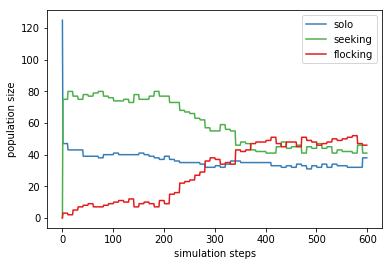

In [9]:
color_fl = '#e41a1c'
color_so = '#377eb8'
color_se = '#4daf4a'

fig = plt.figure()
ax = fig.gca()
plt.plot(range(simulation_steps), 
         [sum([1 for b in N if observe[id(b)]['status'][t] == 'solo'])
          for t in range(simulation_steps)],         
         color=color_so, label='solo')
plt.plot(range(simulation_steps), 
         [sum([1 for b in N if observe[id(b)]['status'][t] == 'seeking'])
          for t in range(simulation_steps)],         
         color=color_se, label='seeking')
plt.plot(range(simulation_steps), 
         [sum([1 for b in N if observe[id(b)]['status'][t] == 'flocking'])
          for t in range(simulation_steps)],         
         color=color_fl, label='flocking')

ax.set_ylabel('population size')
ax.set_xlabel('simulation steps')
ax.legend()
plt.show()

### Average flock size

As time goes by there are more flocks of larger size.

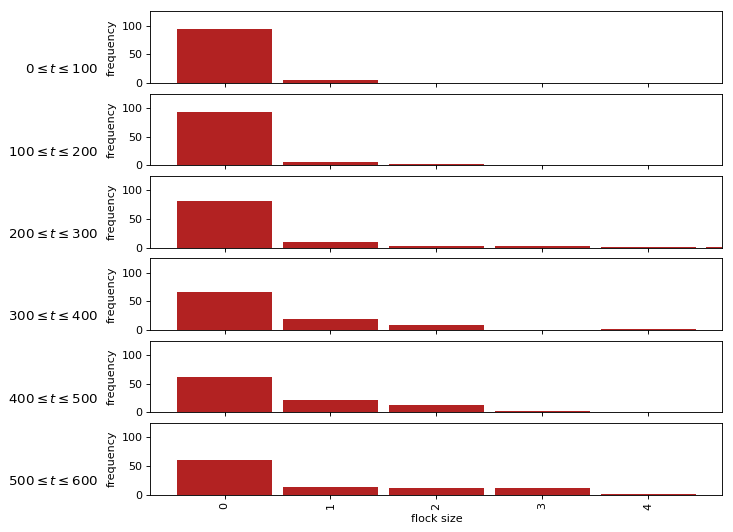

In [10]:
import pandas as pd

f, axarr = plt.subplots(6, 1,
                        sharex=True,
                        figsize=(11, 8), dpi=80)
plt.setp(axarr.flat, xlabel='flock size', ylabel='frequency')

mf = pd.DataFrame({id(b): pd.DataFrame(observe[id(b)])['flock_size'] for b in N})

step = simulation_steps / 6
x = 0
bins = {t: [] for t in range(0, simulation_steps, step)}
for t in range(0, simulation_steps, step):
    hk = mf.loc[t:t+99]
    result = hk.apply(pd.value_counts).fillna(0)
    for i in result.index:
        bins[t].append(result.loc[i].mean())

    df = pd.DataFrame(bins[t])
    df.plot.bar(ax=axarr[x], width=0.9, legend=False, color='firebrick')
    axarr[x].set_ylim(0, number_of_agents)
    x += 1

pad = 4
rows = [r'$%s\leq t\leq %s$' % (t, t+step) for t in range(0, simulation_steps, step)]
for ax, row in zip(axarr[:], rows):
    ax.annotate(row, xy=(0, 0.1), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')

f.subplots_adjust(hspace=0.15)
f.subplots_adjust(left=0.25)

### Plot some frames

 - Blue dots represent solo cyclists.
 - Green dots are seeking to join a flock.
 - Red dots are agents in flocking status, dot size represents flock size
 

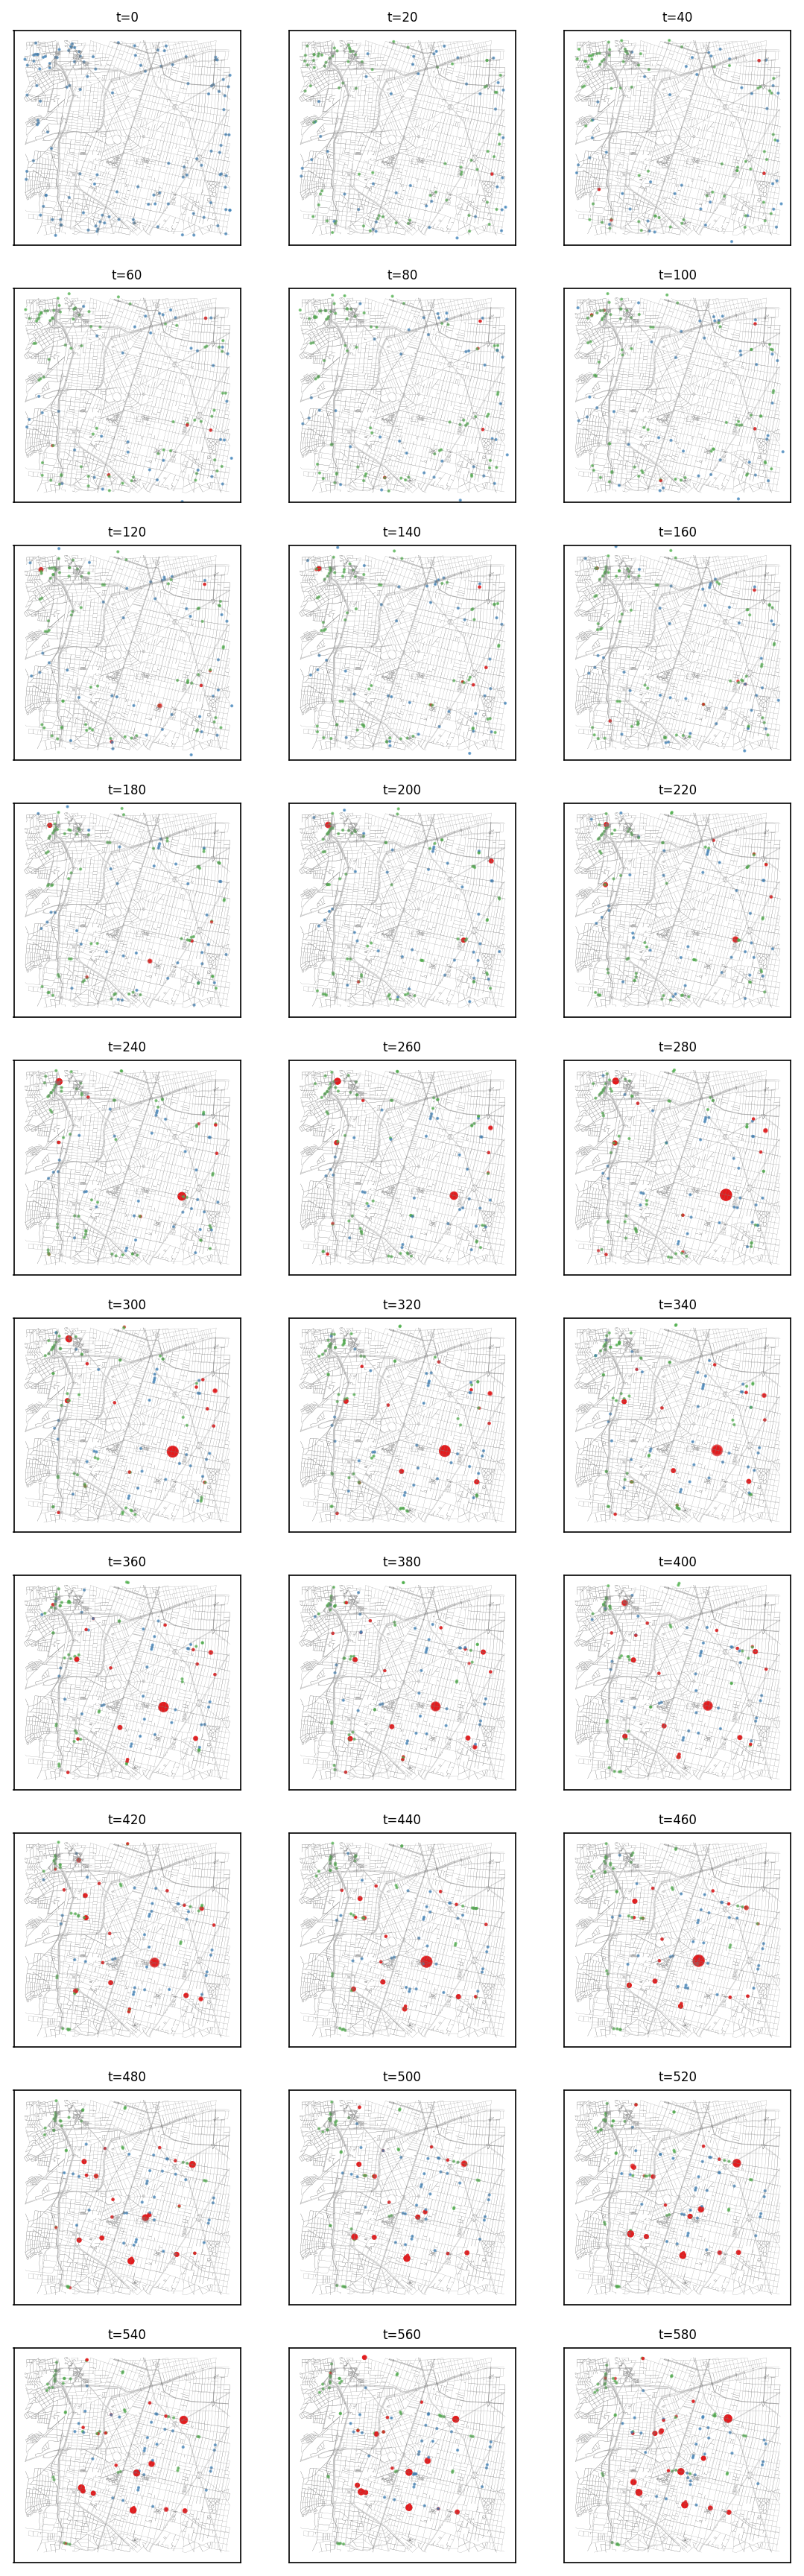

In [11]:
# get edges of street network into geodataframe, for easier re-use
gdf = ox.plot.graph_to_gdfs(G, nodes=False)

rows = 10
cols = 3
frames = rows * cols 

fig, axes = plt.subplots(nrows=rows, ncols=cols,
                         sharex='all', sharey='all',
                         figsize=(3*3, 10*3), dpi=150)

axes = axes.flat

render_interval = simulation_steps / frames
for ax, t in zip(axes, range(frames)):
    # plot streets
    gdf.plot(ax=ax, linewidth=0.1, color="grey")
   
    # mark agent locations at current timestep
    for b in N:
        
        if observe[id(b)]['status'][t*render_interval] == 'solo':
            color = color_so
            size = 0.00018
        elif observe[id(b)]['status'][t*render_interval] == 'seeking':
            color = color_se
            size = 0.00018
        elif observe[id(b)]['status'][t*render_interval] == 'flocking':
            color = color_fl
            size = 0.0002 * observe[id(b)]['flock_size'][t*render_interval]
        
        if observe[id(b)]['status'][t] is not 'arrived':
            ax.add_artist(plt.Circle((observe[id(b)]['lon'][t*render_interval],
                                      observe[id(b)]['lat'][t*render_interval]),
                                     size, color=color, alpha=0.65))
    ax.set_title("t=%s" % (t*20), fontdict={'fontsize': 8})
    ax.set_xticks([]) 
    ax.set_yticks([]) 

plt.show()

### Write data files

Trip logs are written to output files in the results directory.

In [12]:
import os
import pandas as pd

results_dir = os.path.join("results", str(number_of_agents), 'trip_data')

# create output dir
if not os.path.isdir(results_dir):
    os.makedirs(results_dir)

for i in range(len(N)):  # use numerical index instead of object id
    b = N[i]
    df = pd.DataFrame(observe[id(b)])
    df.to_csv(os.path.join(results_dir,
                           "bike_%03i.csv" % i))
    
results_dir

'results/125/trip_data'

[Examine results](results/125/trip_data)

### Render animation

A script is included that will use output data files to render frames for an animation of a simulation run.

Run it thusly:

     $ python render_frames.py --outdir results/125/frames --csv results/125/trip_data/bike_*csv
    
Frames will be written to the specified output directory, and can then be joined into a video file. For example, [ffmpeg](https://ffmpeg.org/) can be used to create a fifteen frames per second animation, with this command:

    $ cd results/125/frames
    
    $ ffmpeg -r 15 -start_number 00000 -i frame_%05d.png simulation_run.mp4


#### Here are some rendered animations

-   <https://archive.org/details/ride_050bikes_cdneza>

-   <https://archive.org/details/ride_100bikes_xochimilco>

-   <https://archive.org/details/ride_100bikes_uacm>

-   <https://archive.org/details/ride_200bikes_cdneza>


